# Process
In this notebook, I will train the music recommendation algorithms using  <a href="https://cornac.readthedocs.io/en/latest/">Cornac</a>. 

**Note:** This notebook has been refactored to automate the evaluation across all combinations of user grouping strategies (`pop_notion`) and evaluation strategies (`choice`/`eva`). It performs one-time computations first (data loading, model training) and then loops through the combinations for evaluation and result saving.

## A. Import libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # Use notebook version for better display
import pickle as pkl
import time
import os

# Cornac imports
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader as CornacReader #Reader exists in both packages
from cornac.models import MostPop, MF, PMF, HPF, ItemKNN, UserKNN
from cornac.models import NMF as CornacNMF #NMF exists in both packages
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR

from collections import defaultdict
from scipy import stats
from sklearn.metrics import mean_squared_error, precision_score, recall_score, ndcg_score
from numpy.linalg import norm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# set plot style: grey grid in the background:
sns.set(style="darkgrid")
pd.set_option("display.precision", 8)

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [2]:
# constants and initialization
rating_threshold = 1.0 # needed for the cornac library: Threshold used to binarize rating values into positive or negative feedback for model evaluation using ranking metrics (rating metrics are not affected). 
my_seed = 0
test_size = 0.2 # the percentage of "hold out" data that are used for testing
predict_col = "rating"
user_col = "user"
item_col = "artist"
top_fraction = 0.2 # the amount of items that will be considered "popular", also user group split fraction
rec_k = 10 # Number of items to recommend
results_location = 'results/' # Folder to save results

# Create results directory if it doesn't exist
os.makedirs(results_location, exist_ok=True)

rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy stuff

## C. Read files

In [3]:
# Using the relevant_music_data_20.csv as per original notebook logic when alt_dataset=True
user_events_file = 'data/relevant_music_data_20.csv'
df_events_orig = pd.read_csv(user_events_file, index_col=0)

print('No. user-item interactions: ' + str(len(df_events_orig)))
df_events_orig = df_events_orig.astype({user_col: "int", item_col: "int", predict_col: "int"})

No. user-item interactions: 1008479


In [4]:
df_events_orig.head()

,user,artist,rating
0,1021445,12,43
1,1021445,16,1
2,1021445,28,7
3,1021445,29,1
4,1021445,46,1


## D. Data analysis & Preprocessing

### D.1 Define Analysis Functions

In [5]:
def users_and_items(df_events, user_col, item_col):
    print('No. user events: ' + str(len(df_events)))
    print('No. items: ' + str(len(df_events[item_col].unique())))
    print('No. users: ' + str(len(df_events[user_col].unique())))
    print("\n")
def user_distribution(df_events, user_col, item_col):
    user_dist = df_events[user_col].value_counts() 
    num_users = len(user_dist)
    print('Mean '+item_col+'s per user: ' + str(np.round(user_dist.mean(),1))) 
    print('Min '+item_col+'s per user: ' + str(np.round(user_dist.min(),1))) 
    print('Max '+item_col+'s per user: ' + str(np.round(user_dist.max(),1)))
    print("\n")
    return user_dist, num_users
def item_distribution(df_events, user_col, item_col):
    item_dist = df_events[item_col].value_counts()
    num_items = len(item_dist)
    print('Mean users per '+item_col+': ' + str(np.round(item_dist.mean(),1))) 
    print('Min users per '+item_col+': ' + str(np.round(item_dist.min(),1))) 
    print('Max users per '+item_col+': ' + str(np.round(item_dist.max(),1))) 
    print("\n")
    return item_dist, num_items

### D.2 Run Initial Analysis

In [6]:
users_and_items(df_events_orig, user_col, item_col)
user_dist, num_users = user_distribution(df_events_orig, user_col, item_col)
item_dist, num_items = item_distribution(df_events_orig, user_col, item_col)

No. user events: 1008479
No. items: 12690
No. users: 3000


Mean artists per user: 336.2
Min artists per user: 4
Max artists per user: 2057


Mean users per artist: 79.5
Min users per artist: 21
Max users per artist: 1389




### D.3 Calculate Base Item Popularity

In [7]:
# create item dataframe with item counts and normalized popularity
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
df_item_dist['popularity'] = df_item_dist['count'] / num_users # Normalized popularity

# Identify top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top] # Uses the Series with raw counts
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 2538


In [8]:
df_item_dist.head()

,count,popularity
artist,,
135,1389,0.46300000
1602,1359,0.45300000
46,1325,0.44166667
320,1297,0.43233333
27,1290,0.43000000


### D.4 Define Plotting Functions

In [9]:
def plot_data_distribution(item_dist, item_col, dividing = [False, 0], log = False):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        x0 = int(len(item_dist.values)*dividing[1])
        y = range(len(item_dist))
        plt.plot(y[:x0+1], item_dist.values[:x0+1], label = "Popular "+item_col+"s", linewidth = 5)
        plt.plot(y[x0:], item_dist.values[x0:], label = "Non Popular "+item_col+"s", linewidth = 5)
    else:
        plt.plot(item_dist.values)
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    add = ""
    if log:
        plt.xscale('log')
        plt.yscale('log')
        add = " (log)"
    plt.title(f'{item_col} Popularity Distribution{add}') # Added title
    plt.xlabel(item_col+add, fontsize='14')
    plt.ylabel('Number of users' + add, fontsize='15')
    plt.show(block=False) # Use non-blocking show for automated runs
    plt.close() # Close plot to free memory

# This function is less relevant in an automated run generating many results, but kept for potential manual checks
def plot_popularity_distribution(pop_fraq, item_col, dividing = [False,0]):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        y = range(len(pop_fraq))
        x0 = int(len(y)*dividing[1]) 
        x1 = int(len(y)*(1-dividing[1]))
        x= sorted(pop_fraq)
        plt.plot(y[:x0+1],x[:x0+1], label="LowMS users", linewidth = 5)
        plt.plot(y[x0:x1+1],x[x0:x1+1], label = "MedMS users", linewidth = 5)
        plt.plot(y[x1:],x[x1:], label = "HighMS users", linewidth =5)
    else:
        plt.plot(sorted(pop_fraq))
    plt.title(f'User Distribution by Ratio of Popular {item_col}s') # Added title
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    plt.show(block=False)
    plt.close()

# This function is less relevant in an automated run, but kept for potential manual checks
def plot_profile_size_vs_popularity(pop_metric, user_hist, way, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    # Filter out potential NaNs before calculating linregress
    mask = ~np.isnan(user_hist) & ~np.isnan(pop_metric)
    if np.sum(mask) < 2: # Need at least 2 points for regression
        print(f"Skipping plot for '{way}': Insufficient valid data points.")
        plt.close()
        return
    user_hist_valid = np.array(user_hist)[mask]
    pop_metric_valid = np.array(pop_metric)[mask]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist_valid, pop_metric_valid)
    print(f'Profile Size vs Popularity ({way}) R-value: {r_value:.4f}') # Print R-value
    line = slope * user_hist_valid + intercept
    plt.plot(user_hist_valid, pop_metric_valid, 'o', user_hist_valid, line)
    
    if way == "count":
        ylabel = "Number of popular "+item_col+"s"
    elif way == "percentage":
        ylabel = 'Percentage of popular '+item_col+'s'
    else:
        ylabel = "Average popularity of "+item_col+"s"
    plt.title(f'User Profile Size vs {ylabel}') # Added title
    plt.xlabel('User profile size', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel(ylabel, fontsize='15')
    plt.yticks(fontsize='13')
    plt.show(block=False)
    plt.close()

### D.5 Plot Initial Distributions

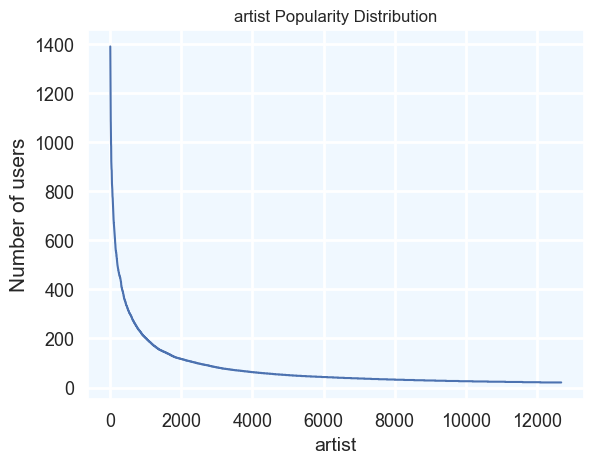

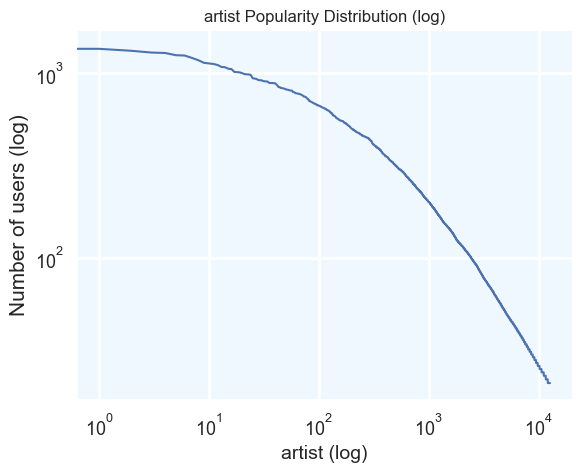

In [10]:
plot_data_distribution(item_dist, item_col)
plot_data_distribution(item_dist, item_col, [False, 0], True)

## E. Calculate Base User Popularity Metrics

Define functions to calculate different user popularity/niche metrics. These will be calculated once and used later for sorting/grouping based on the chosen `pop_notion`.

In [11]:
# Function to read pre-defined user groups for 'pop_three' notion (Not applicable for Music, kept for structure)
def read_mainstream_groups(low_user_file, medium_user_file, high_user_file):
    print("Note: 'pop_three' (mainstreaminess) is not applicable for this dataset.")
    return None, None, None

# Function to calculate GAP and ratios for pre-defined groups ('pop_three') (Not applicable for Music, kept for structure)
def calculate_stats_for_mainstream_groups(df_events, top_item_dist, item_dist_df, num_users, user_col, item_col, low_users, medium_users, high_users):
    print("Skipping mainstream group calculations as 'pop_three' is not applicable.")
    return (np.nan,) * 9 # Return NaNs

# Function to calculate base popularity metrics for all users
def calculate_popularity_metrics(df_events, top_item_dist, item_dist_df, num_users, user_col, item_col):
    # item_dist_df should be the DataFrame with 'popularity' column
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles (GAP in profile)
    user_ids_processed = [] # Keep track of user order
    
    print("Calculating base popularity metrics for all users...")
    for u, df in tqdm(df_events.groupby(user_col), total=df_events[user_col].nunique()):
        user_ids_processed.append(int(u))
        no_user_items = len(set(df[item_col]))
        if no_user_items == 0: # Handle users with no items
             pop_count.append(0)
             user_hist.append(0)
             pop_fraq.append(np.nan)
             pop_item_fraq.append(np.nan)
             continue
             
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        # Use the 'popularity' (normalized) column from df_item_dist for GAP calculation
        user_pop_item_fraq_val = sum(item_dist_df.loc[df[item_col], 'popularity']) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq_val)
        
    # Return as a dictionary mapping user_id to metrics for easier alignment later
    metrics_dict = {
        'user_id': user_ids_processed,
        'pop_count': pop_count,
        'user_hist': user_hist,
        'pop_fraq': pop_fraq,
        'pop_item_fraq': pop_item_fraq
    }
    return pd.DataFrame(metrics_dict).set_index('user_id')

# Function to calculate niche consumption rate
def calculate_niche_consumption_rates(df_events, item_dist_df, user_dist_counts, user_col, item_col, niche_threshold_percentile=0.3):
    # item_dist_df should be the DataFrame with 'count' column
    print(f"Defining niche items (bottom {niche_threshold_percentile*100:.0f}% popularity)...")

    # --- Step 1: Identify Niche Items ---
    item_popularity_values = pd.to_numeric(item_dist_df['count'].values, errors='coerce') # Use raw counts for percentile
    item_popularity_values = item_popularity_values[~np.isnan(item_popularity_values)] # Remove NaNs if any

    if len(item_popularity_values) == 0:
         raise ValueError("Item distribution contains no valid numeric popularity values.")

    popularity_threshold = np.percentile(item_popularity_values, niche_threshold_percentile * 100)

    # Get the IDs of items with popularity count <= threshold
    niche_item_ids = item_dist_df[item_dist_df['count'] <= popularity_threshold].index
    niche_item_set = set(niche_item_ids) # Use a set for efficient lookup
    print(f"Found {len(niche_item_set)} niche items with popularity count <= {popularity_threshold:.2f}.")

    # --- Step 2: Calculate Rate Per User ---
    niche_rates = {}
    user_groups = dict(iter(df_events.groupby(user_col)))

    print("Calculating niche consumption rate per user...")
    # Iterate through users in the order defined by user_dist_counts to ensure alignment
    for u in tqdm(user_dist_counts.index):
        if u not in user_groups:
            print(f"Warning: User {u} found in user_dist_counts but not in df_events. Assigning rate NaN.")
            niche_rates[u] = np.nan
            continue

        df_user = user_groups[u]
        user_items_set = set(df_user[item_col])
        total_user_items = len(user_items_set)

        if total_user_items == 0:
            niche_rates[u] = np.nan # Handle users with no items
            continue

        niche_items_consumed = user_items_set.intersection(niche_item_set)
        niche_item_count = len(niche_items_consumed)

        niche_rate = niche_item_count / total_user_items
        niche_rates[u] = niche_rate

    print("Finished calculating niche consumption rates.")
    # Return as a Series aligned with user_dist_counts index
    return pd.Series(niche_rates, index=user_dist_counts.index, name='niche_consumption_rate')

### E.1 Calculate All Base User Metrics

In [12]:
# Calculate base metrics needed for pop_one, pop_two
base_user_metrics_df = calculate_popularity_metrics(df_events_orig, top_item_dist, df_item_dist, num_users, user_col, item_col)

# Calculate base metrics needed for pop_four
niche_consumption_rates_series = calculate_niche_consumption_rates(
    df_events_orig,
    df_item_dist,      # Pass the DataFrame with 'count' column
    user_dist,         # Pass the user activity Series (value_counts)
    user_col=user_col,
    item_col=item_col,
    niche_threshold_percentile=0.3
)

# Combine all metrics into a single DataFrame aligned by user_id (index)
user_metrics_all = base_user_metrics_df.join(user_dist).join(niche_consumption_rates_series)
user_metrics_all.rename(columns={'count': 'total_interactions'}, inplace=True) # Rename count from user_dist

print("\nCombined User Metrics DataFrame Head:")
user_metrics_all.head()

Calculating base popularity metrics for all users...


  0%|          | 0/3000 [00:00<?, ?it/s]

Defining niche items (bottom 30% popularity)...
Found 3855 niche items with popularity count <= 29.00.
Calculating niche consumption rate per user...


  0%|          | 0/3000 [00:00<?, ?it/s]

Finished calculating niche consumption rates.

Combined User Metrics DataFrame Head:


,pop_count,user_hist,pop_fraq,pop_item_fraq,total_interactions,niche_consumption_rate
user_id,,,,,,
1021445,290,576,0.50347222,0.06502083,576,0.13715278
1045479,275,381,0.72178478,0.10647419,381,0.03149606
1058776,310,441,0.70294785,0.09606425,441,0.06802721
1058825,218,445,0.48988764,0.06326816,445,0.12134831
1070023,239,368,0.64945652,0.09423641,368,0.11141304


### E.2 Define User Grouping Functions

In [13]:
# Function to sort users based on a chosen metric
def sort_users(user_metrics_df, by = "pop_fraq"):
    # Ensure the sorting column exists
    if by not in user_metrics_df.columns:
        raise ValueError(f"Sorting column '{by}' not found in user metrics DataFrame.")
    
    # Sort and return
    user_dist_sorted = user_metrics_df.sort_values(by=[by])
    return user_dist_sorted

# Function to split sorted users into groups
def split(user_dist_sorted, top_fraction):
    n = len(user_dist_sorted)
    idx1 = int(top_fraction * n)
    idx2 = int((1 - top_fraction) * n)
    
    # Handle potential rounding issues causing indices to be equal
    if idx1 >= idx2:
       print(f"Warning: Splitting indices are too close ({idx1}, {idx2}). Adjusting split.")
       # Example adjustment: ensure at least one user in middle group if possible
       if n > 2:
           idx1 = max(0, idx2 - 1)
       else: # Cannot form 3 distinct groups
           idx1 = 0
           idx2 = n // 2 
           print("Cannot form 3 distinct groups with current settings.")
           
    low = user_dist_sorted.iloc[:idx1]
    med = user_dist_sorted.iloc[idx1:idx2]
    high = user_dist_sorted.iloc[idx2:]
    
    # Add check for empty groups
    if low.empty or med.empty or high.empty:
        print(f"Warning: One or more user groups are empty after split (Low: {len(low)}, Med: {len(med)}, High: {len(high)}). Check data and top_fraction.")
        
    return low, med, high

# Function to calculate characteristics for the split groups
def calculate_group_characteristics(low, med, high):
    # Use the calculated 'user_hist' and 'pop_item_fraq' (GAP in profile)
    low_profile_size = low['user_hist'].mean() if not low.empty else np.nan
    med_profile_size = med['user_hist'].mean() if not med.empty else np.nan
    high_profile_size = high['user_hist'].mean() if not high.empty else np.nan
    
    low_nr_users = len(low)
    med_nr_users = len(med)
    high_nr_users = len(high)
    
    low_GAP = low['pop_item_fraq'].mean() if not low.empty else np.nan
    med_GAP = med['pop_item_fraq'].mean() if not med.empty else np.nan
    high_GAP = high['pop_item_fraq'].mean() if not high.empty else np.nan
    
    print(f"Low Group ('Niche', {low_nr_users} users): Avg Profile Size={low_profile_size:.2f}, Avg Profile GAP={low_GAP:.6f}")
    print(f"Med Group ('Diverse', {med_nr_users} users): Avg Profile Size={med_profile_size:.2f}, Avg Profile GAP={med_GAP:.6f}")
    print(f"High Group ('Blockbuster', {high_nr_users} users): Avg Profile Size={high_profile_size:.2f}, Avg Profile GAP={high_GAP:.6f}")
    
    return low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP

### E.3 Define Popularity Propensity Notions

In [14]:
# Maps notion key to the column name in user_metrics_all DataFrame for sorting
popularity_function = {'pop_one': "pop_fraq",             # Sort by fraction of popular items consumed
                       'pop_two': "pop_item_fraq",        # Sort by avg popularity of items consumed (GAP)
                       'pop_three': "mainstreaminess",    # Special case: uses external files (Not applicable for Music)
                       'pop_four': "niche_consumption_rate" # Sort by niche consumption rate (lower value means more niche)
                      }

### E.4 Plot User Metric Distributions (Optional Check)

Plotting base user metric distributions (optional check)...


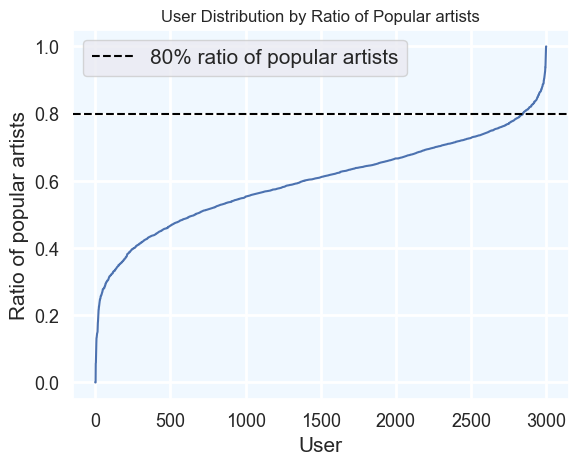

Profile Size vs Popularity (count) R-value: 0.9617


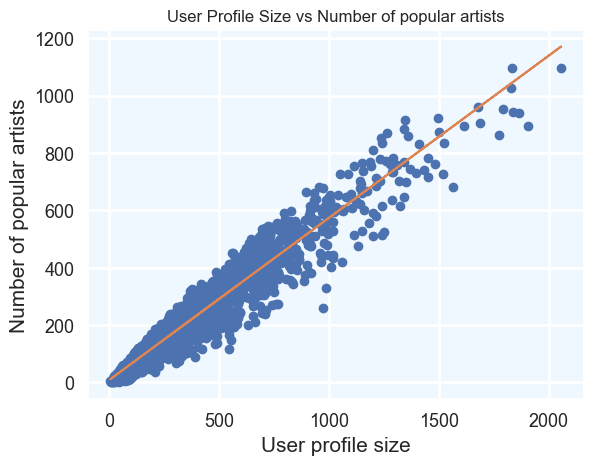

Profile Size vs Popularity (percentage) R-value: -0.0561


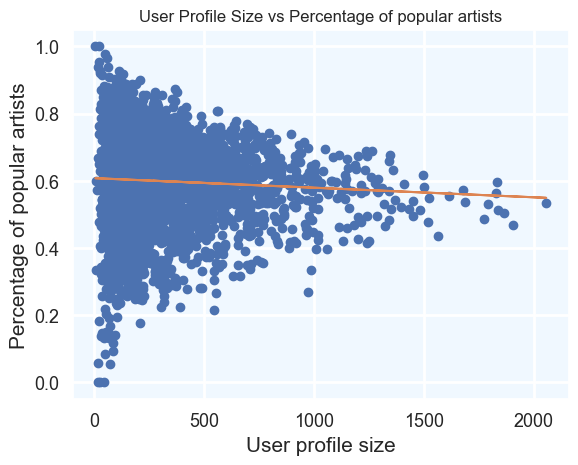

Profile Size vs Popularity (average) R-value: -0.2245


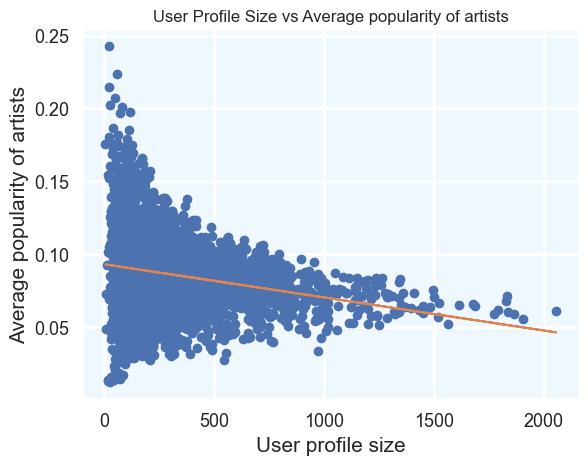

In [15]:
# These plots show distributions based on the calculated metrics before splitting.
# They are less critical for the automated run but useful for understanding the data.
print("Plotting base user metric distributions (optional check)...")
plot_popularity_distribution(user_metrics_all['pop_fraq'].dropna(), item_col)
plot_profile_size_vs_popularity(user_metrics_all['pop_count'].dropna(), user_metrics_all['user_hist'].dropna(), "count", item_col)
plot_profile_size_vs_popularity(user_metrics_all['pop_fraq'].dropna(), user_metrics_all['user_hist'].dropna(), "percentage", item_col)
plot_profile_size_vs_popularity(user_metrics_all['pop_item_fraq'].dropna(), user_metrics_all['user_hist'].dropna(), "average", item_col)

## F. Data Scaling for Cornac Models

In [16]:
# Scale ratings per user to a range (e.g., 1-1000) as done in the original notebook
# This is applied before feeding data to Cornac
print("Scaling user ratings...")
scaled_df_list = [] 

# Group by user and apply scaler
for user_id, group in tqdm(df_events_orig.groupby('user'), total=df_events_orig['user'].nunique()):
    # Check if group has more than one unique rating to scale
    if group[predict_col].nunique() > 1:
        scaler = MinMaxScaler(feature_range=(1, 1000))
        try:
            # Reshape, convert to float, scale
            scaled_ratings = scaler.fit_transform(group[predict_col].values.reshape(-1, 1).astype(float))
        except ValueError as e:
            print(f"Error scaling ratings for user {user_id}: {e}")
            # Handle error: e.g., skip scaling for this user or use original values
            scaled_ratings = group[predict_col].values.reshape(-1, 1).astype(float) # Use original if scaling fails
    else:
        # If only one unique rating, scaling is not meaningful/possible; keep original value(s)
        # Ensure it's float and has the correct shape for consistency
        scaled_ratings = group[predict_col].values.reshape(-1, 1).astype(float)

    new_rows = group.copy()
    new_rows[predict_col] = scaled_ratings.flatten() # Assign scaled ratings back
    scaled_df_list.append(new_rows)

# Concatenate scaled dataframes
df_events_scaled = pd.concat(scaled_df_list, ignore_index=True)

# Verify scaling
print("\nScaled DataFrame head:")
df_events_scaled.head()

Scaling user ratings...


  0%|          | 0/3000 [00:00<?, ?it/s]


Scaled DataFrame head:


,user,artist,rating
0,1021445,12,184.22270742
1,1021445,16,1.00000000
2,1021445,28,27.17467249
3,1021445,29,1.00000000
4,1021445,46,1.00000000


In [17]:
# Use the scaled dataframe for Cornac
df_events = df_events_scaled

## G. Recommendation using Cornac

### G.1 Prepare Data for Cornac

In [18]:
# Map item IDs to continuous integers for Cornac
df_events_cornac = df_events.copy()
mapping_dict = {} # Maps original artist ID to new integer ID
reverse_mapping_dict = {} # Maps new integer ID back to original artist ID
i = 0
for art in df_events_cornac[item_col].unique():
    mapping_dict[art] = i
    reverse_mapping_dict[i] = art
    i += 1
df_events_cornac[item_col] = df_events_cornac[item_col].map(lambda x: mapping_dict.get(x, x))

# Ensure correct types for Cornac (string UIDs and IIDs)
df_events_cornac[user_col] = df_events_cornac[user_col].astype("string")
df_events_cornac[item_col] = df_events_cornac[item_col].astype("string")

# Rename index of item distribution dataframe using the new mapping
# Create df_item_dist_cornac with the *new* string item IDs as index
df_item_dist_cornac = df_item_dist.copy()
df_item_dist_cornac.index = df_item_dist_cornac.index.map(lambda x: str(mapping_dict.get(x, x)))

# Prepare data in Cornac format (list of tuples)
data = list(df_events_cornac[[user_col, item_col, predict_col]].to_records(index=False))

print(f"Prepared {len(data)} interactions for Cornac.")
print("Item distribution indexed by Cornac item ID (string):")
df_item_dist_cornac.head()

Prepared 1008479 interactions for Cornac.
Item distribution indexed by Cornac item ID (string):


,count,popularity
artist,,
591,1389,0.46300000
657,1359,0.45300000
4,1325,0.44166667
27,1297,0.43233333
579,1290,0.43000000


### G.2 Split Data

In [19]:
# Split the data based on ratio
print(f"Splitting data into train/test ({1-test_size:.0%}/{test_size:.0%})...")
rs = RatioSplit(data=data, test_size=test_size, rating_threshold=rating_threshold, seed=my_seed, verbose=True)

# Get all unique item indices known to Cornac
all_items_cornac_indices = set(rs.train_set.iid_map.values()) # Use internal Cornac indices
print(f"Total unique items known to Cornac: {len(all_items_cornac_indices)}")

Splitting data into train/test (80%/20%)...
rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 3000
Number of items = 12690
Number of ratings = 806783
Max rating = 1000.0
Min rating = 1.0
Global mean = 44.5
---
Test data:
Number of users = 3000
Number of items = 12690
Number of ratings = 201696
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 3000
Total items = 12690
Total unique items known to Cornac: 12690


### G.3 Define Models

In [20]:
# Initialize models (matching the original Music notebook)
models = [
          MostPop(),
          UserKNN(k=40, similarity='cosine', mean_centered=False, seed=my_seed, verbose=True),
          ItemKNN(k=40, similarity='cosine', mean_centered=False, seed=my_seed, verbose=True),
          MF(k=30, max_iter=100, learning_rate=0.01, lambda_reg=0.001, seed=my_seed, verbose=True),
          PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001, seed=my_seed, verbose=True),
          CornacNMF(k=15, max_iter=50, learning_rate=0.005, lambda_u=0.06, lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02, use_bias=False, seed=my_seed, verbose=True),
          HPF(k=50, seed=my_seed, hierarchical=False, name="PF", verbose=True)
          ]

algo_names = ["MostPop", 
              "UserKNN",
              "ItemKNN", 
              "MF",
              "PMF",
              "NMF",
              "HPF",
              ] # Corresponds to the 'models' list

### G.4 Train Models

In [21]:
# Define metrics for Cornac experiment run (e.g., MAE for monitoring)
metrics_train = [MAE()]

# Run the Cornac experiment to train all models
print("Training models...")
start_train = time.time()
exp = cornac.Experiment(eval_method=rs, models=models, metrics=metrics_train, user_based=True, verbose=True)
exp.run()
end_train = time.time()
print(f"Training completed in {round(end_train - start_train)} seconds.")

Training models...

[MostPop] Training started!

[MostPop] Evaluation started!


Rating:   0%|          | 0/201696 [00:00<?, ?it/s]


[UserKNN] Training started!


  0%|          | 0/3000 [00:00<?, ?it/s]


[UserKNN] Evaluation started!


Rating:   0%|          | 0/201696 [00:00<?, ?it/s]


[ItemKNN] Training started!


  0%|          | 0/12690 [00:00<?, ?it/s]


[ItemKNN] Evaluation started!


Rating:   0%|          | 0/201696 [00:00<?, ?it/s]


[MF] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!

[MF] Evaluation started!


Rating:   0%|          | 0/201696 [00:00<?, ?it/s]


[PMF] Training started!
Learning...
epoch 0, loss: 155084.795966
epoch 1, loss: 86975.061789
epoch 2, loss: 53418.749656
epoch 3, loss: 38709.684055
epoch 4, loss: 30908.752810
epoch 5, loss: 26151.894519
epoch 6, loss: 23008.108093
epoch 7, loss: 20840.053146
epoch 8, loss: 19296.269270
epoch 9, loss: 18163.060215
epoch 10, loss: 17307.567132
epoch 11, loss: 16645.596483
epoch 12, loss: 16122.517976
epoch 13, loss: 15701.942342
epoch 14, loss: 15358.960617
epoch 15, loss: 15076.048770
epoch 16, loss: 14840.543998
epoch 17, loss: 14643.062929
epoch 18, loss: 14476.492447
epoch 19, loss: 14335.331996
epoch 20, loss: 14215.253792
epoch 21, loss: 14112.801286
epoch 22, loss: 14025.176957
epoch 23, loss: 13950.090024
epoch 24, loss: 13885.645940
epoch 25, loss: 13830.265047
epoch 26, loss: 13782.621197
epoch 27, loss: 13741.594617
epoch 28, loss: 13706.235288
epoch 29, loss: 13675.734138
epoch 30, loss: 13649.400159
epoch 31, loss: 13626.642039
epoch 32, loss: 13606.953356
epoch 33, loss:

Rating:   0%|          | 0/201696 [00:00<?, ?it/s]


[NMF] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!

[NMF] Evaluation started!


Rating:   0%|          | 0/201696 [00:00<?, ?it/s]


[PF] Training started!
Learning...
Learning completed!

[PF] Evaluation started!


Rating:   0%|          | 0/201696 [00:00<?, ?it/s]


TEST:
...
        |      MAE | Train (s) | Test (s)
------- + -------- + --------- + --------
MostPop | 193.9530 |    0.0375 |   2.3118
UserKNN |  66.4852 |    1.6879 |  19.3600
ItemKNN |  65.6744 |    8.3173 |  23.9115
MF      |      nan |    6.6163 |   3.4120
PMF     |  72.1270 |   38.6863 |   3.6547
NMF     |  57.0491 |    4.4360 |   3.8708
PF      |  54.6507 | 1274.9539 |   3.6710

Training completed in 1395 seconds.


### G.5 Define Evaluation Strategies & Recommendation Functions
Define functions to generate recommendations based on the different evaluation strategies identified in the paper:
*   `eva_two` (UserTest): For users in the test set, rank only items rated by that user in the test set. (Kowald et al. [26])
*   `eva_three` (TrainItems): For users in the test set, rank only items *not* rated by that user in the train set. (Abdollahpouri et al. [3])

In [22]:
# Evaluation Strategy 2: UserTest (Kowald et al. 2010)
def get_top_n_eva_two(model, user_idx_map, test_set, rec_k=10):
    top_n = defaultdict(list)
    item_idx_map = model.train_set.iid_map
    idx_item_map = {v: k for k, v in item_idx_map.items()}
    for uid in tqdm(test_set.uid_map.values(), desc="Generating recs (eva_two)"):
        if uid in test_set.user_data:
            original_user_id = user_idx_map[uid]
            candidate_items_indices = test_set.user_data[uid][0]
            if not candidate_items_indices: continue
            try:
                item_indices_ranked, item_scores_ranked = model.rank(user_idx=uid, item_indices=candidate_items_indices)
                # Handle potential NaN scores from models like MF
                valid_scores_mask = ~np.isnan(item_scores_ranked)
                item_indices_ranked = np.array(item_indices_ranked)[valid_scores_mask]
                item_scores_ranked = np.array(item_scores_ranked)[valid_scores_mask]
                
                top_k_indices = item_indices_ranked[:rec_k]
                top_k_scores = item_scores_ranked[:rec_k]
                
                for iid, score in zip(top_k_indices, top_k_scores):
                    original_item_id = idx_item_map[iid]
                    top_n[int(original_user_id)].append((int(original_item_id), score))
            except Exception as e:
                 print(f"Error during ranking for user {original_user_id} (eva_two): {e}")
                 continue # Skip user if ranking fails
    return top_n

In [23]:
# Evaluation Strategy 3: TrainItems (Abdollahpouri et al. 2019)
def get_top_n_eva_three(model, user_idx_map, train_set, test_set, all_items_indices, rec_k=10):
    top_n = defaultdict(list)
    item_idx_map = model.train_set.iid_map
    idx_item_map = {v: k for k, v in item_idx_map.items()}
    for uid in tqdm(test_set.uid_map.values(), desc="Generating recs (eva_three)"):
        original_user_id = user_idx_map[uid]
        items_in_train = set()
        if uid in train_set.user_data:
            items_in_train = set(train_set.user_data[uid][0])
        candidate_items_indices = list(all_items_indices.difference(items_in_train))
        if not candidate_items_indices: continue
        try:
            item_indices_ranked, item_scores_ranked = model.rank(user_idx=uid, item_indices=candidate_items_indices)
            # Handle potential NaN scores
            valid_scores_mask = ~np.isnan(item_scores_ranked)
            item_indices_ranked = np.array(item_indices_ranked)[valid_scores_mask]
            item_scores_ranked = np.array(item_scores_ranked)[valid_scores_mask]
            
            top_k_indices = item_indices_ranked[:rec_k]
            top_k_scores = item_scores_ranked[:rec_k]
            
            for iid, score in zip(top_k_indices, top_k_scores):
                original_item_id = idx_item_map[iid]
                top_n[int(original_user_id)].append((int(original_item_id), score))
        except Exception as e:
             print(f"Error during ranking for user {original_user_id} (eva_three): {e}")
             continue # Skip user if ranking fails
    return top_n

### G.6 Define Evaluation Functions (NDCG, GAP)

In [24]:
# Function to calculate NDCG per group
def calculate_NDCG_per_group(algo_name, model_index, recommendations, cornac_exp, low_group_users, med_group_users, high_group_users, rec_k=10):
    model = cornac_exp.models[model_index]
    rs = cornac_exp.eval_method
    train_set = rs.train_set
    test_set = rs.test_set
    
    ndcg_low = []
    ndcg_med = []
    ndcg_high = []
    
    low_ids = set(low_group_users.index.astype(int))
    med_ids = set(med_group_users.index.astype(int))
    high_ids = set(high_group_users.index.astype(int))
    
    orig_uid_to_cornac_uid = train_set.uid_map
    orig_iid_to_cornac_iid = train_set.iid_map
    
    print(f"Calculating NDCG@{rec_k} for {algo_name}...")
    for user_id_int, user_ratings in tqdm(recommendations.items(), desc=f"NDCG {algo_name}"):
        user_id_str = str(user_id_int)
        
        if user_id_str not in orig_uid_to_cornac_uid or orig_uid_to_cornac_uid[user_id_str] not in test_set.user_data:
            continue
            
        uid_cornac = orig_uid_to_cornac_uid[user_id_str]
        true_item_indices, true_relevance_scores = test_set.user_data[uid_cornac]
        true_relevance_dict = dict(zip(true_item_indices, true_relevance_scores))
        
        user_pred_scores = []
        user_true_scores = []
        
        for (item_id_int, pred_score) in user_ratings:
            # Handle potential NaN prediction scores
            if pd.isna(pred_score):
                # print(f"Warning: NaN prediction score for user {user_id_int}, item {item_id_int} in {algo_name}. Assigning 0 relevance.")
                user_pred_scores.append(-np.inf) # Assign very low score for ranking
                user_true_scores.append(0.0)
                continue
                
            item_id_str = str(item_id_int)
            user_pred_scores.append(pred_score)
            true_score = 0.0
            if item_id_str in orig_iid_to_cornac_iid:
                iid_cornac = orig_iid_to_cornac_iid[item_id_str]
                if iid_cornac in true_relevance_dict:
                    true_score = true_relevance_dict[iid_cornac]
            user_true_scores.append(true_score)
            
        if len(user_true_scores) > 1:
            true_relevance_arr = np.asarray([user_true_scores])
            pred_scores_arr = np.asarray([user_pred_scores])
            # Check if all true scores are zero, ndcg_score might raise error
            if np.all(true_relevance_arr == 0):
                 user_ndcg = 0.0 # Assign 0 if no relevant items recommended
            else:
                try:
                    user_ndcg = ndcg_score(true_relevance_arr, pred_scores_arr, k=rec_k)
                except ValueError as e:
                    # print(f"Could not calculate NDCG for user {user_id_int}: {e}")
                    user_ndcg = np.nan # Assign NaN if calculation fails
            
            if not pd.isna(user_ndcg):
                if user_id_int in low_ids:
                    ndcg_low.append(user_ndcg)
                elif user_id_int in med_ids:
                    ndcg_med.append(user_ndcg)
                elif user_id_int in high_ids:
                    ndcg_high.append(user_ndcg)

    mean_ndcg_low = np.nanmean(ndcg_low) if ndcg_low else np.nan
    mean_ndcg_med = np.nanmean(ndcg_med) if ndcg_med else np.nan
    mean_ndcg_high = np.nanmean(ndcg_high) if ndcg_high else np.nan
    
    ttests = [np.nan] * 3
    try:
        if len(ndcg_low) > 1 and len(ndcg_med) > 1:
            ttests[0] = stats.ttest_ind(ndcg_low, ndcg_med, equal_var=False, nan_policy='omit')[1]
        if len(ndcg_low) > 1 and len(ndcg_high) > 1:
            ttests[1] = stats.ttest_ind(ndcg_low, ndcg_high, equal_var=False, nan_policy='omit')[1]
        if len(ndcg_med) > 1 and len(ndcg_high) > 1:
            ttests[2] = stats.ttest_ind(ndcg_med, ndcg_high, equal_var=False, nan_policy='omit')[1]
    except Exception as e:
        print(f"Error during t-test calculation for NDCG ({algo_name}): {e}")
            
    return mean_ndcg_low, mean_ndcg_med, mean_ndcg_high, ttests

## H. Automated Evaluation Loop

### H.1 Generate Recommendations for Each Evaluation Strategy

In [25]:
# Define the evaluation strategies to run
evaluation_function_map = {'eva_two': get_top_n_eva_two, 'eva_three': get_top_n_eva_three}

# Store all recommendations keyed by evaluation strategy
all_recommendations = {}

# Precompute user index map (internal cornac index -> original string uid)
user_idx_map = {v: k for k, v in rs.train_set.uid_map.items()}

# Loop through each evaluation strategy and generate recommendations for all algorithms
start_rec = time.time()
for eva_key, eva_func in evaluation_function_map.items():
    print(f"--- Generating Recommendations for Evaluation Strategy: {eva_key} ---")
    algo_recommendations = {} # Store recommendations for algorithms under this strategy
    for i, algo_name in enumerate(algo_names):
        model = exp.models[i]
        print(f"Generating recommendations for: {algo_name} ({eva_key})")
        if eva_key == 'eva_two':
            top_n = eva_func(model, user_idx_map, rs.test_set, rec_k=rec_k)
        elif eva_key == 'eva_three':
            top_n = eva_func(model, user_idx_map, rs.train_set, rs.test_set, all_items_cornac_indices, rec_k=rec_k)
        else:
            print(f"Warning: Unknown evaluation strategy key '{eva_key}'. Skipping.")
            continue
        algo_recommendations[algo_name] = top_n # Store as dict {user: [(item, score)]}
        
    all_recommendations[eva_key] = algo_recommendations
end_rec = time.time()
print(f"\nRecommendation generation completed in {round(end_rec - start_rec)} seconds.")

# Optional: Save recommendations
# with open(results_location + 'all_recommendations_music.pickle', 'wb') as handle:
#     pkl.dump(all_recommendations, handle)
# To load: 
# with open(results_location + 'all_recommendations_music.pickle', 'rb') as handle:
#     all_recommendations = pkl.load(handle)

--- Generating Recommendations for Evaluation Strategy: eva_two ---
Generating recommendations for: MostPop (eva_two)


Generating recs (eva_two):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: UserKNN (eva_two)


Generating recs (eva_two):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: ItemKNN (eva_two)


Generating recs (eva_two):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: MF (eva_two)


Generating recs (eva_two):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: PMF (eva_two)


Generating recs (eva_two):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: NMF (eva_two)


Generating recs (eva_two):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: HPF (eva_two)


Generating recs (eva_two):   0%|          | 0/3000 [00:00<?, ?it/s]

--- Generating Recommendations for Evaluation Strategy: eva_three ---
Generating recommendations for: MostPop (eva_three)


Generating recs (eva_three):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: UserKNN (eva_three)


Generating recs (eva_three):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: ItemKNN (eva_three)


Generating recs (eva_three):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: MF (eva_three)


Generating recs (eva_three):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: PMF (eva_three)


Generating recs (eva_three):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: NMF (eva_three)


Generating recs (eva_three):   0%|          | 0/3000 [00:00<?, ?it/s]

Generating recommendations for: HPF (eva_three)


Generating recs (eva_three):   0%|          | 0/3000 [00:00<?, ?it/s]


Recommendation generation completed in 2061 seconds.


### H.2 Run Evaluation for Each Combination

In [26]:
start_eval = time.time()

# Iterate through each evaluation strategy (for which recommendations were generated)
for eva_key, current_algo_recommendations in all_recommendations.items():
    
    # Iterate through each popularity notion for user grouping
    for pop_key, pop_sort_col in popularity_function.items():
        # Skip pop_three for music dataset
        if pop_key == "pop_three":
            print(f"\n--- Skipping Evaluation for: eva={eva_key}, pop={pop_key} (Not applicable) ---")
            continue
            
        print(f"\n--- Running Evaluation for: eva={eva_key}, pop={pop_key} ---")

        # --- 1. Determine user groups (low, med, high) and their profile GAPs --- 
        low_group = None
        med_group = None
        high_group = None
        low_GAP_profile = np.nan
        med_GAP_profile = np.nan
        high_GAP_profile = np.nan

        # Sort and split users based on calculated metrics
        print(f"Sorting users by '{pop_sort_col}' and splitting...")
        try:
            # Ensure the sorting column exists and handle potential NaNs before sorting
            if pop_sort_col not in user_metrics_all.columns:
                 raise ValueError(f"Sorting column '{pop_sort_col}' not found.")
            # Drop users with NaN in the sorting column before sorting
            user_metrics_to_sort = user_metrics_all.dropna(subset=[pop_sort_col])
            if user_metrics_to_sort.empty:
                raise ValueError(f"No users remaining after dropping NaNs for sorting column '{pop_sort_col}'.")
                
            user_dist_sorted = sort_users(user_metrics_to_sort, by=pop_sort_col)
            low_group, med_group, high_group = split(user_dist_sorted, top_fraction)
            # Calculate group characteristics for this split
            _, _, _, _, _, _, low_GAP_profile, med_GAP_profile, high_GAP_profile = \
                calculate_group_characteristics(low_group, med_group, high_group)
        except ValueError as e:
            print(f"Error during user sorting/splitting for pop_key='{pop_key}': {e}. Skipping evaluation.")
            continue
        except IndexError as e:
             print(f"Error during group splitting (likely too few users or bad top_fraction): {e}. Skipping evaluation for pop_key='{pop_key}'.")
             continue
             
        # Check if groups or GAPs are invalid
        if (low_group is None or med_group is None or high_group is None or
            low_group.empty or med_group.empty or high_group.empty or
            pd.isna(low_GAP_profile) or pd.isna(med_GAP_profile) or pd.isna(high_GAP_profile)):
                print(f"Skipping evaluation for pop_key='{pop_key}' due to invalid groups or profile GAPs.")
                continue

        # --- 2. Calculate NDCG --- 
        NDCGs = pd.DataFrame(index=algo_names, columns=['low', 'med', 'high']).fillna(np.nan)
        TTESTs_ndcg = pd.DataFrame(index=algo_names, columns=['low-med', 'low-high', 'med-high']).fillna(np.nan)
        for i, algo_name in enumerate(algo_names):
             recommendations_for_algo = current_algo_recommendations[algo_name]
             ndcg_low, ndcg_med, ndcg_high, ttests = calculate_NDCG_per_group(algo_name, i, recommendations_for_algo, exp, low_group, med_group, high_group, rec_k)
             NDCGs.loc[algo_name] = ndcg_low, ndcg_med, ndcg_high
             TTESTs_ndcg.loc[algo_name] = ttests

        # --- 3. Calculate %ΔGAP --- 
        low_gap_vals_list = []
        medium_gap_vals_list = []
        high_gap_vals_list = []
        gap_ttests_list = []
        
        df_item_dist_cornac_eval = df_item_dist_cornac.copy()
        if 'popularity' not in df_item_dist_cornac_eval.columns:
             df_item_dist_cornac_eval['popularity'] = df_item_dist_cornac_eval['count'] / num_users
             
        print(f"Calculating %DeltaGAP for {eva_key}, {pop_key}...")
        for i, algo_name in enumerate(algo_names):
            low_rec_gap_user = []
            medium_rec_gap_user = []
            high_rec_gap_user = []

            recommendations_for_algo = current_algo_recommendations[algo_name]
            for uid_int, user_ratings in tqdm(recommendations_for_algo.items(), desc=f"GAP {algo_name}"):
                iid_list_int = [iid for (iid, _) in user_ratings]
                if not iid_list_int: continue
                
                iid_list_str = [str(iid) for iid in iid_list_int]
                valid_iids_str = [iid_str for iid_str in iid_list_str if iid_str in df_item_dist_cornac_eval.index]
                
                if not valid_iids_str: continue

                # Calculate GAP for this user's recommendations using item 'popularity'
                gap = sum(df_item_dist_cornac_eval.loc[valid_iids_str, 'popularity']) / len(valid_iids_str)
                
                # Skip if GAP is NaN (e.g., due to NaN scores in recommendations)
                if pd.isna(gap):
                    # print(f"Warning: NaN GAP calculated for user {uid_int} in {algo_name}. Skipping user for GAP avg.")
                    continue 

                if uid_int in low_group.index:
                    low_rec_gap_user.append(gap)
                elif uid_int in med_group.index:
                    medium_rec_gap_user.append(gap)
                elif uid_int in high_group.index:
                    high_rec_gap_user.append(gap)
            
            mean_gap_rec_low = np.nanmean(low_rec_gap_user) if low_rec_gap_user else np.nan
            mean_gap_rec_med = np.nanmean(medium_rec_gap_user) if medium_rec_gap_user else np.nan
            mean_gap_rec_high = np.nanmean(high_rec_gap_user) if high_rec_gap_user else np.nan
            
            # Calculate %ΔGAP only if profile GAP is valid (non-NaN and non-zero)
            delta_gap_low = (mean_gap_rec_low - low_GAP_profile) / low_GAP_profile * 100 if pd.notna(low_GAP_profile) and low_GAP_profile != 0 and pd.notna(mean_gap_rec_low) else np.nan
            delta_gap_med = (mean_gap_rec_med - med_GAP_profile) / med_GAP_profile * 100 if pd.notna(med_GAP_profile) and med_GAP_profile != 0 and pd.notna(mean_gap_rec_med) else np.nan
            delta_gap_high = (mean_gap_rec_high - high_GAP_profile) / high_GAP_profile * 100 if pd.notna(high_GAP_profile) and high_GAP_profile != 0 and pd.notna(mean_gap_rec_high) else np.nan
            
            low_gap_vals_list.append(delta_gap_low)
            medium_gap_vals_list.append(delta_gap_med)
            high_gap_vals_list.append(delta_gap_high)
            
            # Calculate t-tests for %ΔGAP differences (using individual user relative differences)
            rel_diff_low = [(g - low_GAP_profile) / low_GAP_profile for g in low_rec_gap_user if pd.notna(g)] if pd.notna(low_GAP_profile) and low_GAP_profile != 0 else []
            rel_diff_med = [(g - med_GAP_profile) / med_GAP_profile for g in medium_rec_gap_user if pd.notna(g)] if pd.notna(med_GAP_profile) and med_GAP_profile != 0 else []
            rel_diff_high = [(g - high_GAP_profile) / high_GAP_profile for g in high_rec_gap_user if pd.notna(g)] if pd.notna(high_GAP_profile) and high_GAP_profile != 0 else []
            
            ttests_gap = [np.nan] * 3
            try:
                if len(rel_diff_low) > 1 and len(rel_diff_med) > 1:
                     ttests_gap[0] = stats.ttest_ind(rel_diff_low, rel_diff_med, equal_var=False, nan_policy='omit')[1]
                if len(rel_diff_low) > 1 and len(rel_diff_high) > 1:
                     ttests_gap[1] = stats.ttest_ind(rel_diff_low, rel_diff_high, equal_var=False, nan_policy='omit')[1]
                if len(rel_diff_med) > 1 and len(rel_diff_high) > 1:
                     ttests_gap[2] = stats.ttest_ind(rel_diff_med, rel_diff_high, equal_var=False, nan_policy='omit')[1]
            except Exception as e:
                 print(f"Error during t-test calculation for GAP ({algo_name}): {e}")
            gap_ttests_list.append(ttests_gap)

        # --- 4. Save results for this combination --- 
        print(f"Saving results for eva={eva_key}, pop={pop_key}...")
        
        NDCGs.to_csv(results_location + f'NDCGs_music_{eva_key}_{pop_key}.csv')
        TTESTs_ndcg.to_csv(results_location + f'NDCG_ttests_music_{eva_key}_{pop_key}.csv')
        
        # Save GAP results as lists (containing floats or NaNs)
        gap_results_dict = {
            'low': low_gap_vals_list,
            'med': medium_gap_vals_list,
            'high': high_gap_vals_list
        }
        df_gap_results = pd.DataFrame(gap_results_dict, index=algo_names)
        df_gap_results.to_csv(results_location + f'PercentDeltaGAP_music_{eva_key}_{pop_key}.csv')
        
        # Save t-tests for GAP
        df_gap_ttests = pd.DataFrame(gap_ttests_list, index=algo_names, columns=['low-med', 'low-high', 'med-high'])
        df_gap_ttests.to_csv(results_location + f'GAP_ttests_music_{eva_key}_{pop_key}.csv')

# --- 5. Save Base Item Distribution --- 
print("\nSaving base item distribution (indexed by Cornac item ID)...")
df_item_dist_cornac.to_csv(results_location + 'df_item_dist_cornac_music_base.csv')

end_eval = time.time()
print(f"\nEvaluation for all combinations completed in {round(end_eval - start_eval)} seconds.")


--- Running Evaluation for: eva=eva_two, pop=pop_one ---
Sorting users by 'pop_fraq' and splitting...
Low Group ('Niche', 600 users): Avg Profile Size=303.26, Avg Profile GAP=0.051648
Med Group ('Diverse', 1800 users): Avg Profile Size=380.66, Avg Profile GAP=0.084701
High Group ('Blockbuster', 600 users): Avg Profile Size=235.56, Avg Profile GAP=0.121155
Calculating NDCG@10 for MostPop...


NDCG MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for UserKNN...


NDCG UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for ItemKNN...


NDCG ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for MF...


NDCG MF: 0it [00:00, ?it/s]

Calculating NDCG@10 for PMF...


NDCG PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for NMF...


NDCG NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for HPF...


NDCG HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating %DeltaGAP for eva_two, pop_one...


GAP MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP MF: 0it [00:00, ?it/s]

GAP PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Saving results for eva=eva_two, pop=pop_one...

--- Running Evaluation for: eva=eva_two, pop=pop_two ---
Sorting users by 'pop_item_fraq' and splitting...
Low Group ('Niche', 600 users): Avg Profile Size=336.87, Avg Profile GAP=0.049812
Med Group ('Diverse', 1800 users): Avg Profile Size=385.25, Avg Profile GAP=0.083783
High Group ('Blockbuster', 600 users): Avg Profile Size=188.19, Avg Profile GAP=0.125745
Calculating NDCG@10 for MostPop...


NDCG MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for UserKNN...


NDCG UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for ItemKNN...


NDCG ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for MF...


NDCG MF: 0it [00:00, ?it/s]

Calculating NDCG@10 for PMF...


NDCG PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for NMF...


NDCG NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for HPF...


NDCG HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating %DeltaGAP for eva_two, pop_two...


GAP MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP MF: 0it [00:00, ?it/s]

GAP PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Saving results for eva=eva_two, pop=pop_two...

--- Skipping Evaluation for: eva=eva_two, pop=pop_three (Not applicable) ---

--- Running Evaluation for: eva=eva_two, pop=pop_four ---
Sorting users by 'niche_consumption_rate' and splitting...
Low Group ('Niche', 600 users): Avg Profile Size=262.23, Avg Profile GAP=0.115610
Med Group ('Diverse', 1800 users): Avg Profile Size=377.53, Avg Profile GAP=0.085114
High Group ('Blockbuster', 600 users): Avg Profile Size=285.96, Avg Profile GAP=0.055953
Calculating NDCG@10 for MostPop...


NDCG MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for UserKNN...


NDCG UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for ItemKNN...


NDCG ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for MF...


NDCG MF: 0it [00:00, ?it/s]

Calculating NDCG@10 for PMF...


NDCG PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for NMF...


NDCG NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for HPF...


NDCG HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating %DeltaGAP for eva_two, pop_four...


GAP MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP MF: 0it [00:00, ?it/s]

GAP PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Saving results for eva=eva_two, pop=pop_four...

--- Running Evaluation for: eva=eva_three, pop=pop_one ---
Sorting users by 'pop_fraq' and splitting...
Low Group ('Niche', 600 users): Avg Profile Size=303.26, Avg Profile GAP=0.051648
Med Group ('Diverse', 1800 users): Avg Profile Size=380.66, Avg Profile GAP=0.084701
High Group ('Blockbuster', 600 users): Avg Profile Size=235.56, Avg Profile GAP=0.121155
Calculating NDCG@10 for MostPop...


NDCG MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for UserKNN...


NDCG UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for ItemKNN...


NDCG ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for MF...


NDCG MF: 0it [00:00, ?it/s]

Calculating NDCG@10 for PMF...


NDCG PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for NMF...


NDCG NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for HPF...


NDCG HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating %DeltaGAP for eva_three, pop_one...


GAP MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP MF: 0it [00:00, ?it/s]

GAP PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Saving results for eva=eva_three, pop=pop_one...

--- Running Evaluation for: eva=eva_three, pop=pop_two ---
Sorting users by 'pop_item_fraq' and splitting...
Low Group ('Niche', 600 users): Avg Profile Size=336.87, Avg Profile GAP=0.049812
Med Group ('Diverse', 1800 users): Avg Profile Size=385.25, Avg Profile GAP=0.083783
High Group ('Blockbuster', 600 users): Avg Profile Size=188.19, Avg Profile GAP=0.125745
Calculating NDCG@10 for MostPop...


NDCG MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for UserKNN...


NDCG UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for ItemKNN...


NDCG ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for MF...


NDCG MF: 0it [00:00, ?it/s]

Calculating NDCG@10 for PMF...


NDCG PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for NMF...


NDCG NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for HPF...


NDCG HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating %DeltaGAP for eva_three, pop_two...


GAP MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP MF: 0it [00:00, ?it/s]

GAP PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Saving results for eva=eva_three, pop=pop_two...

--- Skipping Evaluation for: eva=eva_three, pop=pop_three (Not applicable) ---

--- Running Evaluation for: eva=eva_three, pop=pop_four ---
Sorting users by 'niche_consumption_rate' and splitting...
Low Group ('Niche', 600 users): Avg Profile Size=262.23, Avg Profile GAP=0.115610
Med Group ('Diverse', 1800 users): Avg Profile Size=377.53, Avg Profile GAP=0.085114
High Group ('Blockbuster', 600 users): Avg Profile Size=285.96, Avg Profile GAP=0.055953
Calculating NDCG@10 for MostPop...


NDCG MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for UserKNN...


NDCG UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for ItemKNN...


NDCG ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for MF...


NDCG MF: 0it [00:00, ?it/s]

Calculating NDCG@10 for PMF...


NDCG PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for NMF...


NDCG NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating NDCG@10 for HPF...


NDCG HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculating %DeltaGAP for eva_three, pop_four...


GAP MostPop:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP UserKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP ItemKNN:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP MF: 0it [00:00, ?it/s]

GAP PMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP NMF:   0%|          | 0/3000 [00:00<?, ?it/s]

GAP HPF:   0%|          | 0/3000 [00:00<?, ?it/s]

Saving results for eva=eva_three, pop=pop_four...

Saving base item distribution (indexed by Cornac item ID)...

Evaluation for all combinations completed in 71 seconds.
